In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import rankdata, zscore, pearsonr, spearmanr
from scipy.spatial.distance import pdist, squareform
import pandas as pd
from statsmodels.tsa.stattools import acf

In [2]:
# Load in embeddings and transformations for black
black_emb = np.load('black_bert-base-uncased_all_layer_activations.npy')
black_z = np.load('black_bert-base-uncased_all_z_activations.npy')

In [3]:
# Load in embeddings and transformations for slumlord
slumlord_emb = np.genfromtxt('slumlord_embeddings.txt')
slumlord_z = np.load('slumlordreach_bert-base-uncased_all_z_activations.npy')

In [4]:
# Check input data shapes
print(f"black embeddings: {black_emb.shape}")
print(f"black Zs: {black_z.shape}")
print(f"slumlord embeddings: {slumlord_emb.shape}")
print(f"slumlord Zs: {slumlord_emb.shape}")

black embeddings: (534, 9984)
black Zs: (534, 9216)
slumlord embeddings: (601, 9984)
slumlord Zs: (601, 9984)


In [5]:
# Compute rank percentile of RDM
def rank_percentile(rdm):
    return rankdata(rdm) / len(rdm) * 100

In [6]:
# Compute RDMs
black_emb_rdm = pdist(zscore(black_emb, axis=0), metric='correlation')
slumlord_emb_rdm = pdist(zscore(slumlord_emb, axis=0), metric='correlation')
black_z_rdm = pdist(zscore(black_z, axis=0), metric='correlation')
slumlord_z_rdm = pdist(zscore(slumlord_z, axis=0), metric='correlation')

/var/folders/ch/f_vp72713hg84pcp6t_2wfmw0000gp/T/ipykernel_75636/1327260910.py:17: MatplotlibDeprecationWarning: 
The 'update_ticks' parameter of set_ticks() was deprecated in Matplotlib 3.5 and will be removed two minor releases later. If any parameter follows 'update_ticks', they should be passed as keyword, not positionally.
  cbar.set_ticks([0, 100], [0, 100])


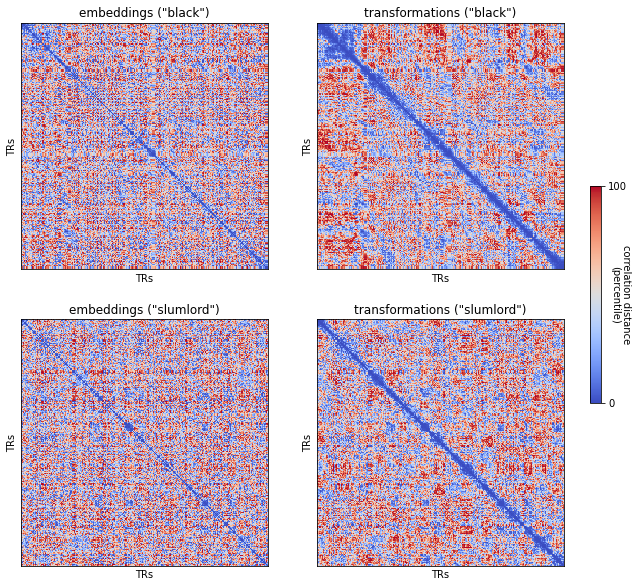

In [7]:
# Plot RDMs for embeddings and transformations
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

rdms = [black_emb_rdm, black_z_rdm,
        slumlord_emb_rdm, slumlord_z_rdm]
titles = ['embeddings ("black")', 'transformations ("black")',
          'embeddings ("slumlord")', 'transformations ("slumlord")']

for ax, rdm, title in zip(axs.ravel(), rdms, titles):
    m = ax.matshow(squareform(rank_percentile(rdm)),
               cmap='coolwarm', vmin=0, vmax=100);
    ax.set(xticks=[], yticks=[], xlabel='TRs', ylabel='TRs',
           title=title)
cbar = fig.colorbar(m, ax=axs, location='right', shrink=0.4, pad=0.04)
cbar.ax.set_ylabel('correlation distance\n(percentile)',
                   rotation=270)
cbar.set_ticks([0, 100], [0, 100])
plt.savefig('rdms_all-layers_supp.png', bbox_inches='tight', dpi=300)

In [8]:
# Get Spearman correlation between embedding and transformation RDMs
print(f'black spearman: {spearmanr(black_emb_rdm, black_z_rdm)[0]:.3f}')
print(f'slumlord spearman: {spearmanr(slumlord_emb_rdm, slumlord_z_rdm)[0]:.3f}')

black spearman: 0.769
slumlord spearman: 0.815


In [9]:
# Compute autocorrelation across all features
def array_acf(data, nlags=30):
    acs = []
    for ts in data.T:
        acs.append(acf(ts, nlags=nlags))
    return np.array(acs).T

In [10]:
# Compute autocorrelation for black
black_ac = {'autocorrelation': [], 'lag': [], 'BERT feature': []}
for label, data in zip(['embeddings', 'transformations'],
                       [black_emb, black_z]):
    ac = array_acf(data)
    for l, lag in enumerate(ac):
        for f in lag:
            black_ac['autocorrelation'].append(f)
            black_ac['lag'].append(l)
            black_ac['BERT feature'].append(label)
black_ac = pd.DataFrame(black_ac)

In [11]:
# Compute autocorrelation for slumlord
slumlord_ac = {'autocorrelation': [], 'lag': [], 'BERT feature': []}
for label, data in zip(['embeddings', 'transformations'],
                       [slumlord_emb, slumlord_z]):
    ac = array_acf(data)
    for l, lag in enumerate(ac):
        for f in lag:
            slumlord_ac['autocorrelation'].append(f)
            slumlord_ac['lag'].append(l)
            slumlord_ac['BERT feature'].append(label)
slumlord_ac = pd.DataFrame(slumlord_ac)

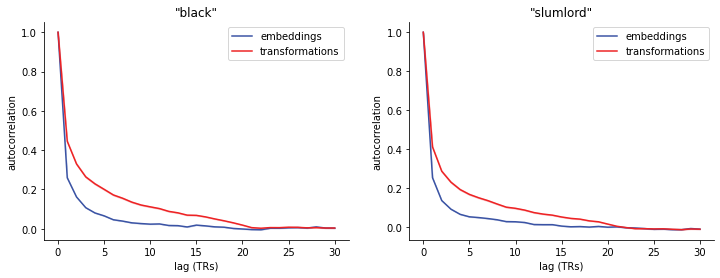

In [12]:
# Plot autocorrelation for black and slumlord
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
sns.lineplot(x='lag', y='autocorrelation', hue='BERT feature',
             data=black_ac, palette=['#3a53a4ff', '#ed2224ff'],
             ax=axs[0])
axs[0].set(xlabel='lag (TRs)', title='"black"')
handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles=handles, labels=labels)
sns.lineplot(x='lag', y='autocorrelation', hue='BERT feature',
             data=slumlord_ac, palette=['#3a53a4ff', '#ed2224ff'],
             ax=axs[1])
axs[1].set(xlabel='lag (TRs)', title='"slumlord"')
handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(handles=handles, labels=labels)
sns.despine()
plt.savefig('autocorrelation_supp.png', bbox_inches='tight', dpi=300)

In [13]:
# Split and re-stack layers
black_emb_lay = np.vstack(np.split(zscore(black_emb[:, 768:], axis=0),
                                   12, axis=1))
black_z_lay = np.vstack(np.split(zscore(black_z, axis=0), 12, axis=1))

slumlord_emb_lay = np.vstack(np.split(zscore(slumlord_emb[:, 768:], axis=0),
                                      12, axis=1))
slumlord_z_lay = np.vstack(np.split(zscore(slumlord_z, axis=0), 12, axis=1))

In [14]:
# Compute layerwise RDMs
black_emb_lay_rdm = pdist(black_emb_lay, metric='correlation')
black_z_lay_rdm = pdist(black_z_lay, metric='correlation')
slumlord_emb_lay_rdm = pdist(slumlord_emb_lay, metric='correlation')
slumlord_z_lay_rdm = pdist(slumlord_z_lay, metric='correlation')

/var/folders/ch/f_vp72713hg84pcp6t_2wfmw0000gp/T/ipykernel_75636/1020834510.py:17: MatplotlibDeprecationWarning: 
The 'update_ticks' parameter of set_ticks() was deprecated in Matplotlib 3.5 and will be removed two minor releases later. If any parameter follows 'update_ticks', they should be passed as keyword, not positionally.
  cbar.set_ticks([0, 100], [0, 100])


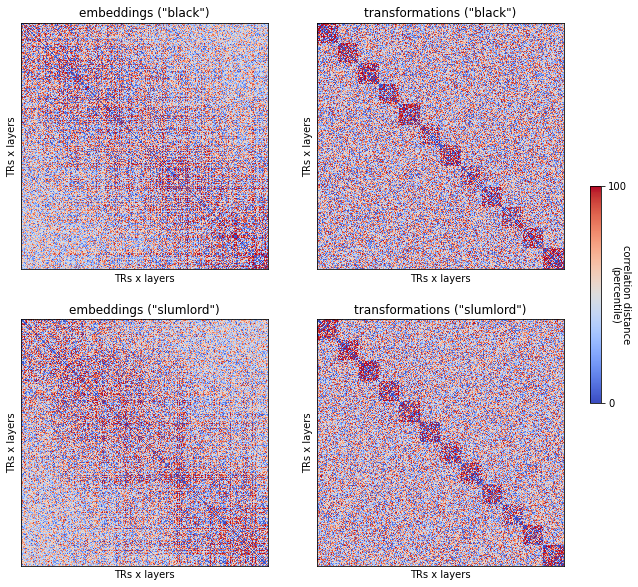

In [15]:
# Plot RDMs for embeddings and transformations
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

rdms = [black_emb_lay_rdm, black_z_lay_rdm,
        slumlord_emb_lay_rdm, slumlord_z_lay_rdm]
titles = ['embeddings ("black")', 'transformations ("black")',
          'embeddings ("slumlord")', 'transformations ("slumlord")']

for ax, rdm, title in zip(axs.ravel(), rdms, titles):
    m = ax.matshow(squareform(rank_percentile(rdm)),
               cmap='coolwarm', vmin=0, vmax=100);
    ax.set(xticks=[], yticks=[], xlabel='TRs x layers',
           ylabel='TRs x layers', title=title)
cbar = fig.colorbar(m, ax=axs, location='right', shrink=0.4, pad=0.04)
cbar.ax.set_ylabel('correlation distance\n(percentile)',
                   rotation=270)
cbar.set_ticks([0, 100], [0, 100])
plt.savefig('rdms_layer-stack_supp.png', bbox_inches='tight', dpi=300)

In [16]:
# Get Spearman correlation between embedding and transformation RDMs
print(f'black spearman: {spearmanr(black_emb_lay_rdm, black_z_lay_rdm)[0]:.3f}')
print(f'slumlord spearman: {spearmanr(slumlord_emb_lay_rdm, slumlord_z_lay_rdm)[0]:.3f}')

black spearman: 0.080
slumlord spearman: 0.083


In [17]:
# Split and re-stack layers
black_emb_lay = np.split(zscore(black_emb[:, 768:], axis=0), 12, axis=1)
black_z_lay = np.split(zscore(black_z, axis=0), 12, axis=1)

slumlord_emb_lay = np.split(zscore(slumlord_emb[:, 768:], axis=0), 12, axis=1)
slumlord_z_lay = np.split(zscore(slumlord_z, axis=0), 12, axis=1)

In [18]:
# Compute second-order layerwise RDMs
black_emb_lw_rdm = pdist(np.stack(
    [pdist(black_emb_lay[l], metric='correlation') for l in np.arange(12)], 0),
                         metric='correlation')
black_z_lw_rdm = pdist(np.stack(
    [pdist(black_z_lay[l], metric='correlation') for l in np.arange(12)], 0),
                       metric='correlation')
slumlord_emb_lw_rdm = pdist(np.stack(
    [pdist(slumlord_emb_lay[l], metric='correlation') for l in np.arange(12)], 0),
                            metric='correlation')
slumlord_z_lw_rdm = pdist(np.stack(
    [pdist(slumlord_z_lay[l], metric='correlation') for l in np.arange(12)], 0),
                         metric='correlation')

/var/folders/ch/f_vp72713hg84pcp6t_2wfmw0000gp/T/ipykernel_75636/1350806595.py:21: MatplotlibDeprecationWarning: 
The 'update_ticks' parameter of set_ticks() was deprecated in Matplotlib 3.5 and will be removed two minor releases later. If any parameter follows 'update_ticks', they should be passed as keyword, not positionally.
  cbar.set_ticks([0, 100], [0, 100])


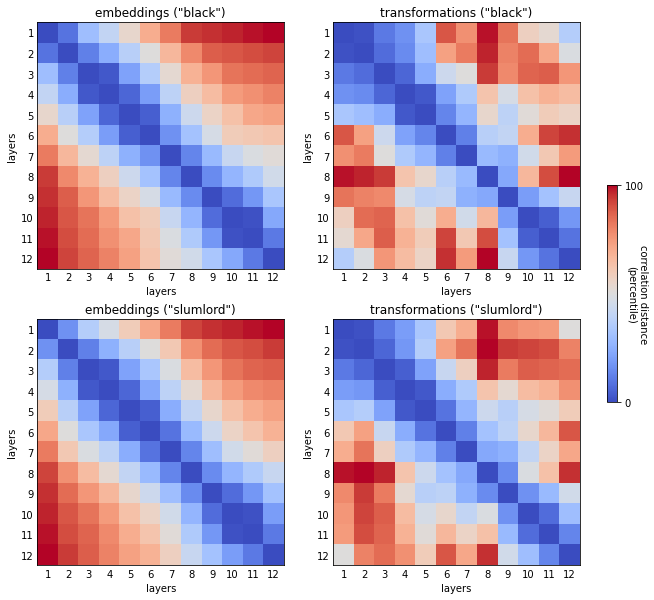

In [19]:
# Plot RDMs for embeddings and transformations
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

rdms = [black_emb_lw_rdm, black_z_lw_rdm,
        slumlord_emb_lw_rdm, slumlord_z_lw_rdm]
titles = ['embeddings ("black")', 'transformations ("black")',
          'embeddings ("slumlord")', 'transformations ("slumlord")']

for ax, rdm, title in zip(axs.ravel(), rdms, titles):
    m = ax.matshow(squareform(rank_percentile(rdm)),
               cmap='coolwarm', vmin=0, vmax=100);
    ax.set_xticks(np.arange(12), np.arange(1, 13))
    ax.set_yticks(np.arange(12), np.arange(1, 13))
    ax.tick_params(axis=u'both', which=u'both', length=0)
    ax.xaxis.set_ticks_position('bottom')
    ax.set(xlabel='layers', ylabel='layers',
           title=title)
cbar = fig.colorbar(m, ax=axs, location='right', shrink=0.4, pad=0.04)
cbar.ax.set_ylabel('correlation distance\n(percentile)',
                   rotation=270)
cbar.set_ticks([0, 100], [0, 100])
plt.savefig('rdms_layerwise_supp.png', bbox_inches='tight', dpi=300)

In [20]:
# Get Spearman correlation between second-order RDMs
print(f'black spearman: {spearmanr(black_emb_lw_rdm, black_z_lw_rdm)[0]:.3f}')
print(f'slumlord spearman: {spearmanr(slumlord_emb_lw_rdm, slumlord_z_lw_rdm)[0]:.3f}')

black spearman: 0.750
slumlord spearman: 0.848


In [21]:
# Compute TR-by-TR similarity between embeddings and transformations
n_trs = black_emb.shape[0] + slumlord_emb.shape[0]

emb_stack = np.vstack((black_emb, slumlord_emb))
z_stack = np.vstack((black_z, slumlord_z)) 

tr_corrs = []
for tr in np.arange(n_trs):
    tr_corrs.append(pearsonr(emb_stack[tr, 768:], z_stack[tr])[0])
    
print(f'mean: {np.mean(tr_corrs):.3f}')
print(f'SD: {np.std(tr_corrs):.3f}')

mean: -0.004
SD: 0.009
